# **1. *Library Setup***

In [129]:
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans,  DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster
from datetime import datetime

# **2. *Data Loading***

In [2]:
"""
DOWNLOADING Bank Transaction Dataset
"""
! gdown 16pyvW9fYZBKFKCsUDKbzg4xQpmCwpCV5

Downloading...
From: https://drive.google.com/uc?id=16pyvW9fYZBKFKCsUDKbzg4xQpmCwpCV5
To: /content/bank_transactions_data_2.csv
100% 345k/345k [00:00<00:00, 56.0MB/s]


In [141]:
"""
Overview of Dataset
"""
df = pd.read_csv('/content/bank_transactions_data_2.csv')

print("-" * 80)
print(df.info())
print("-" * 80)
df.head(5)

--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 1

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


# **3. *Data Understanding***

### 3.1 *Exploratory Data Analysis* (EDA)

since our goals is to search for potential fraud transaction we won't erase the outliers  

In [4]:
df.describe()

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance
count,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000
mean,297.593778,44.673965,119.643312,1.124602,5114.302966
std,291.946243,17.792198,69.963757,0.602662,3900.942499
min,0.260000,18.000000,10.000000,1.000000,101.250000
25%,81.885000,27.000000,63.000000,1.000000,1504.370000
50%,211.140000,45.000000,112.500000,1.000000,4735.510000
75%,414.527500,59.000000,161.000000,1.000000,7678.820000
max,1919.110000,80.000000,300.000000,5.000000,14977.990000


In [6]:
unique_locations = df['Location'].unique()
location_coords = {}
geolocator = Nominatim(user_agent="location_mapper")
for location in unique_locations:
    try:
        loc = geolocator.geocode(location)
        if loc:
            location_coords[location] = (loc.latitude, loc.longitude)
        else:
            print(f"Coordinates not found for {location}")
    except Exception as e:
        print(f"Error fetching coordinates for {location} : {e}")

df['Coordinates'] = df['Location'].map(location_coords)

initial_coords = list(location_coords.values())[0] if location_coords else [0, 0]
mymap = folium.Map(location = initial_coords, zoom_start=5)

for _, row in df.iterrows():
    if row['Coordinates']:
        folium.Marker(
            location=row['Coordinates'],
            popup=f"TransactionID: {row['TransactionID']}<br>Amount: ${row['TransactionAmount']}",
            tooltip=row['Location']
        ).add_to(mymap)

mymap.save('/content/transaction_map.html')

Downloading...
From: https://drive.google.com/uc?id=1DJmHtwDqT2A1KaimRPWtCI4CUrXf83qY
To: /content/bank_fraud_map.png
100% 933k/933k [00:00<00:00, 59.7MB/s]


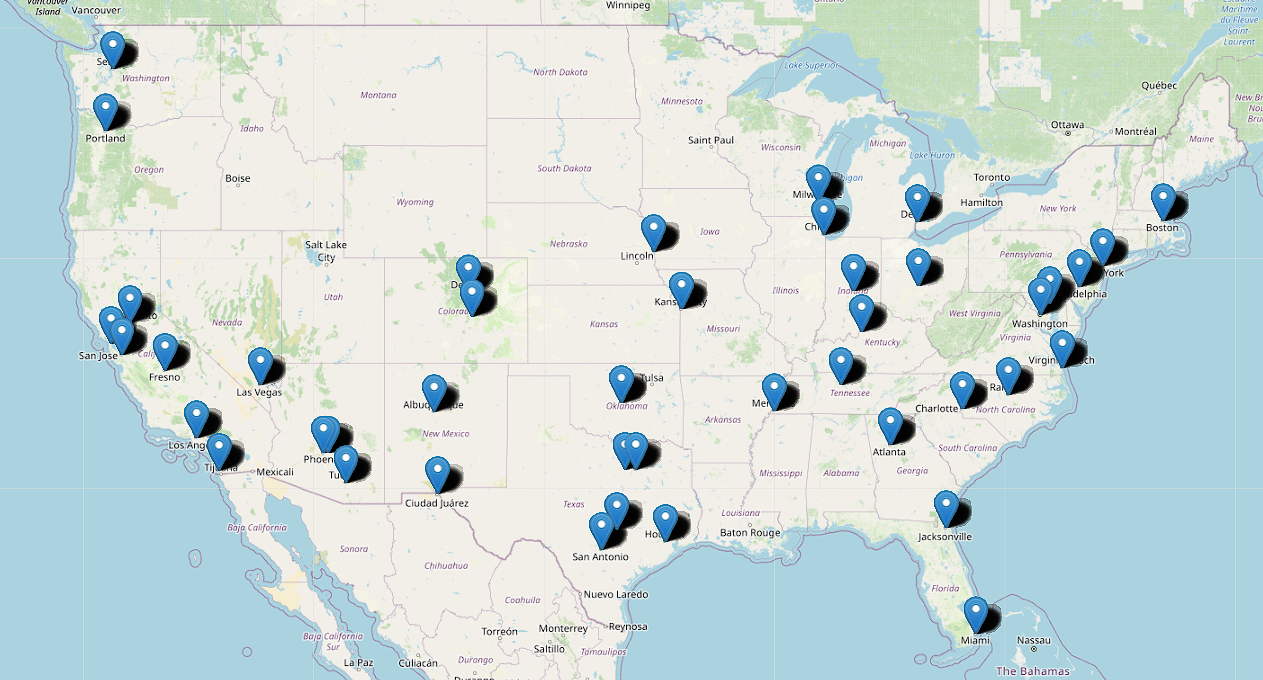

In [7]:
! gdown 1DJmHtwDqT2A1KaimRPWtCI4CUrXf83qY

display(Image(filename='/content/bank_fraud_map.png'))

### 3.1.1 *Univariate Analysis*

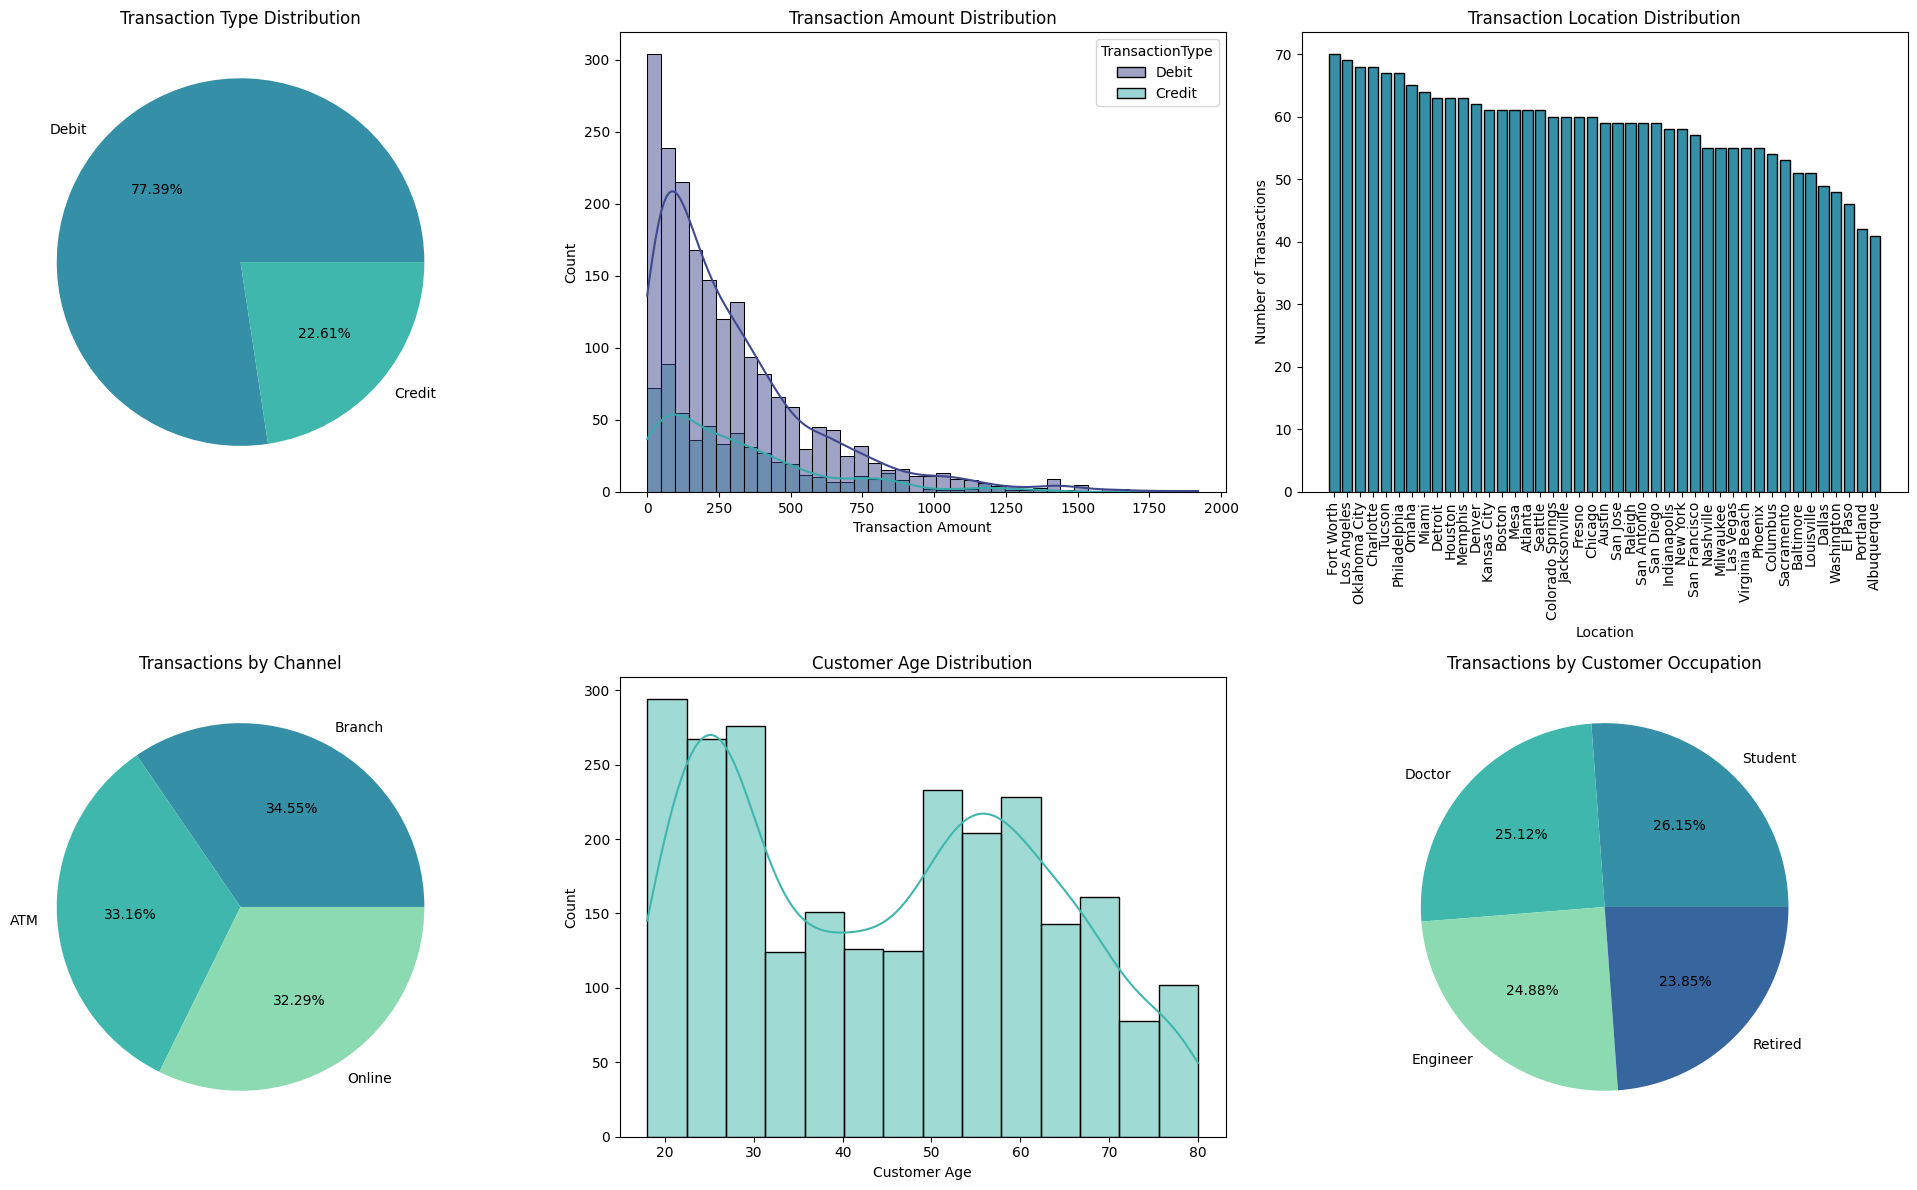

In [142]:
# Create a figure with 2 rows and 3 columns
plt.figure(figsize=(20,12))
palette = sns.color_palette('mako', 6)

# 1. Transaction Type Distribution (Pie Chart)
debitcard_counts = df[df['TransactionType']=='Debit']['TransactionType'].count()
creditcard_counts = df[df['TransactionType']=='Credit']['TransactionType'].count()

plt.subplot(2,3,1)
index_values = [debitcard_counts, creditcard_counts]
index_labels = ['Debit', 'Credit']
plt.pie(index_values, labels=index_labels, autopct='%2.2f%%', colors=[palette[3], palette[4]])
plt.title('Transaction Type Distribution', fontsize=12)

# 2. Transaction Amount Distribution (Histogram)
plt.subplot(2,3,2)
sns.histplot(data=df, x="TransactionAmount", kde=True, hue='TransactionType', palette='mako')
plt.title("Transaction Amount Distribution", fontsize=12)
plt.xlabel("Transaction Amount")
plt.ylabel("Count")

# 3. Transaction Location Distribution (Bar Chart)
location_counts = df['Location'].value_counts()

plt.subplot(2,3,3)
plt.bar(location_counts.index, location_counts.values, color=palette[3], edgecolor='black')
plt.title('Transaction Location Distribution', fontsize=12)
plt.xlabel('Location')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=90)

# 4. Transfer Channel Distribution (Pie Chart)
branch_counts = df[df['Channel']=='Branch']['Channel'].count()
atm_counts = df[df['Channel']=='ATM']['Channel'].count()
online_counts = df[df['Channel']=='Online']['Channel'].count()

plt.subplot(2,3,4)
channel_values = [branch_counts, atm_counts, online_counts]
channel_labels = ['Branch', 'ATM', 'Online']
plt.pie(channel_values, labels=channel_labels, autopct='%2.2f%%', colors=[palette[3], palette[4], palette[5]])
plt.title('Transactions by Channel', fontsize=12)

# 5. Customer Age Distribution (Histogram)
plt.subplot(2,3,5)
sns.histplot(data=df, x='CustomerAge', kde=True, color=palette[4])
plt.title('Customer Age Distribution', fontsize=12)
plt.xlabel('Customer Age')
plt.ylabel('Count')

# 6. Customer Occupation Distribution (Pie Chart)
student_counts = df[df['CustomerOccupation']=='Student']['CustomerOccupation'].count()
doctor_counts = df[df['CustomerOccupation']=='Doctor']['CustomerOccupation'].count()
engineer_counts = df[df['CustomerOccupation']=='Engineer']['CustomerOccupation'].count()
retired_counts = df[df['CustomerOccupation']=='Retired']['CustomerOccupation'].count()

plt.subplot(2,3,6)
occupation_values = [student_counts, doctor_counts, engineer_counts, retired_counts]
occupation_labels = ['Student', 'Doctor', 'Engineer', 'Retired']
plt.pie(occupation_values, labels=occupation_labels, autopct='%2.2f%%', colors=[palette[3], palette[4], palette[5], palette[2]])
plt.title('Transactions by Customer Occupation', fontsize=12)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

from above univariate data analysis we got several information:
1. Majority of transactions are Debit (77.39%), with only 22.61% being Credit.
2. Skewed towards lower transaction amounts.Debit transactions dominate across all ranges, with a few higher-value Credit transactions.
3. High concentration of transactions in cities like Fort Worth, Oklahoma, and Los Angeles, with a gradual decline across other locations.
4. Transactions are evenly split across Branch (34.55%), ATM (33.16%), and Online (32.29%).
5. Peaks at ages 20–30 and 40–50, with a drop-off in the 30–40 age range and older age groups.
6. Fairly even split among Students (26.15%), Doctors (25.12%), Engineers (24.88%), and Retired individuals (23.85%).

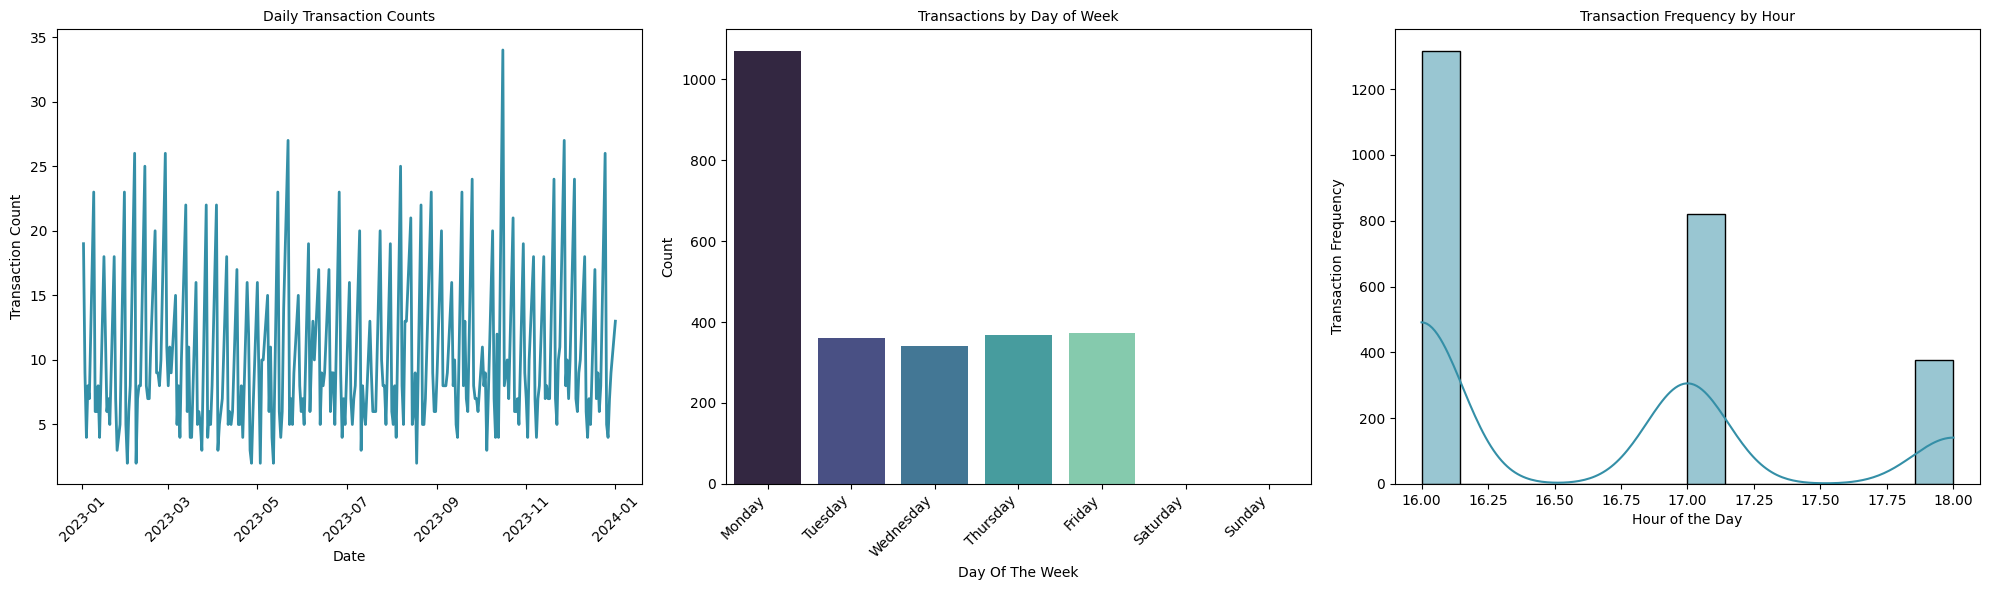

In [143]:
# Create a figure with 1 row and 3 columns
plt.figure(figsize=(20,6))

# 1. Daily Transaction Counts
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['TransactionDay'] = df['TransactionDate'].dt.date
daily_counts = df.groupby('TransactionDay').size()
plt.subplot(1,3,1)
daily_counts.plot(title='Daily Transaction Counts', color=sns.color_palette('mako')[3], linewidth=2)
plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.xticks(rotation=45)
plt.title('Daily Transaction Counts', fontsize=10)

# 2. Weekly Transaction Counts
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['DayOfWeek'] = df['TransactionDate'].dt.day_name()
plt.subplot(1,3,2)
sns.countplot(data=df, x='DayOfWeek', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
              palette=sns.color_palette('mako', 5))
plt.title('Transactions by Day of Week', fontsize=10)
plt.xlabel('Day Of The Week')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# 3. Hourly Transaction Counts
df['Hour'] = df['TransactionDate'].dt.hour
plt.subplot(1,3,3)
sns.histplot(data=df, x='Hour', kde=True, color=sns.color_palette('mako')[3])
plt.title('Transaction Frequency by Hour', fontsize=10)
plt.xlabel('Hour of the Day')
plt.ylabel('Transaction Frequency')

df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['Hour of Transaction'] = df['TransactionDate'].dt.hour
df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'])
df['Time_Gap'] = (df['TransactionDate'] - df['PreviousTransactionDate'])
# Adjust layout and show plot
plt.tight_layout()
plt.show()

from above univariate transaction data accross multiple time frame we got several information:

1. Daily Transaction Counts (Left Plot):
There is high variability in daily transaction counts, fluctuating between 5 and 35 transactions per day.
No strong upward or downward trend is visible over the year, suggesting relatively stable daily activity.
Transactions by Day of the Week (Middle Plot):

2. Most transactions occur on Mondays, with a sharp drop-off on other days of the week.
The least activity seems to happen over the weekend, specifically on Saturday and Sunday.
Transaction Frequency by Hour (Right Plot):

3. Transaction activity is highest around 17:00 (5 PM), indicating a peak in user activity during the late afternoon.
A secondary peak might exist later in the evening, though the frequency significantly drops before and after the main peak at 17:00.
Let me know if you need further breakdowns or insights!

### 3.1.2 *Multivariate Analysis*

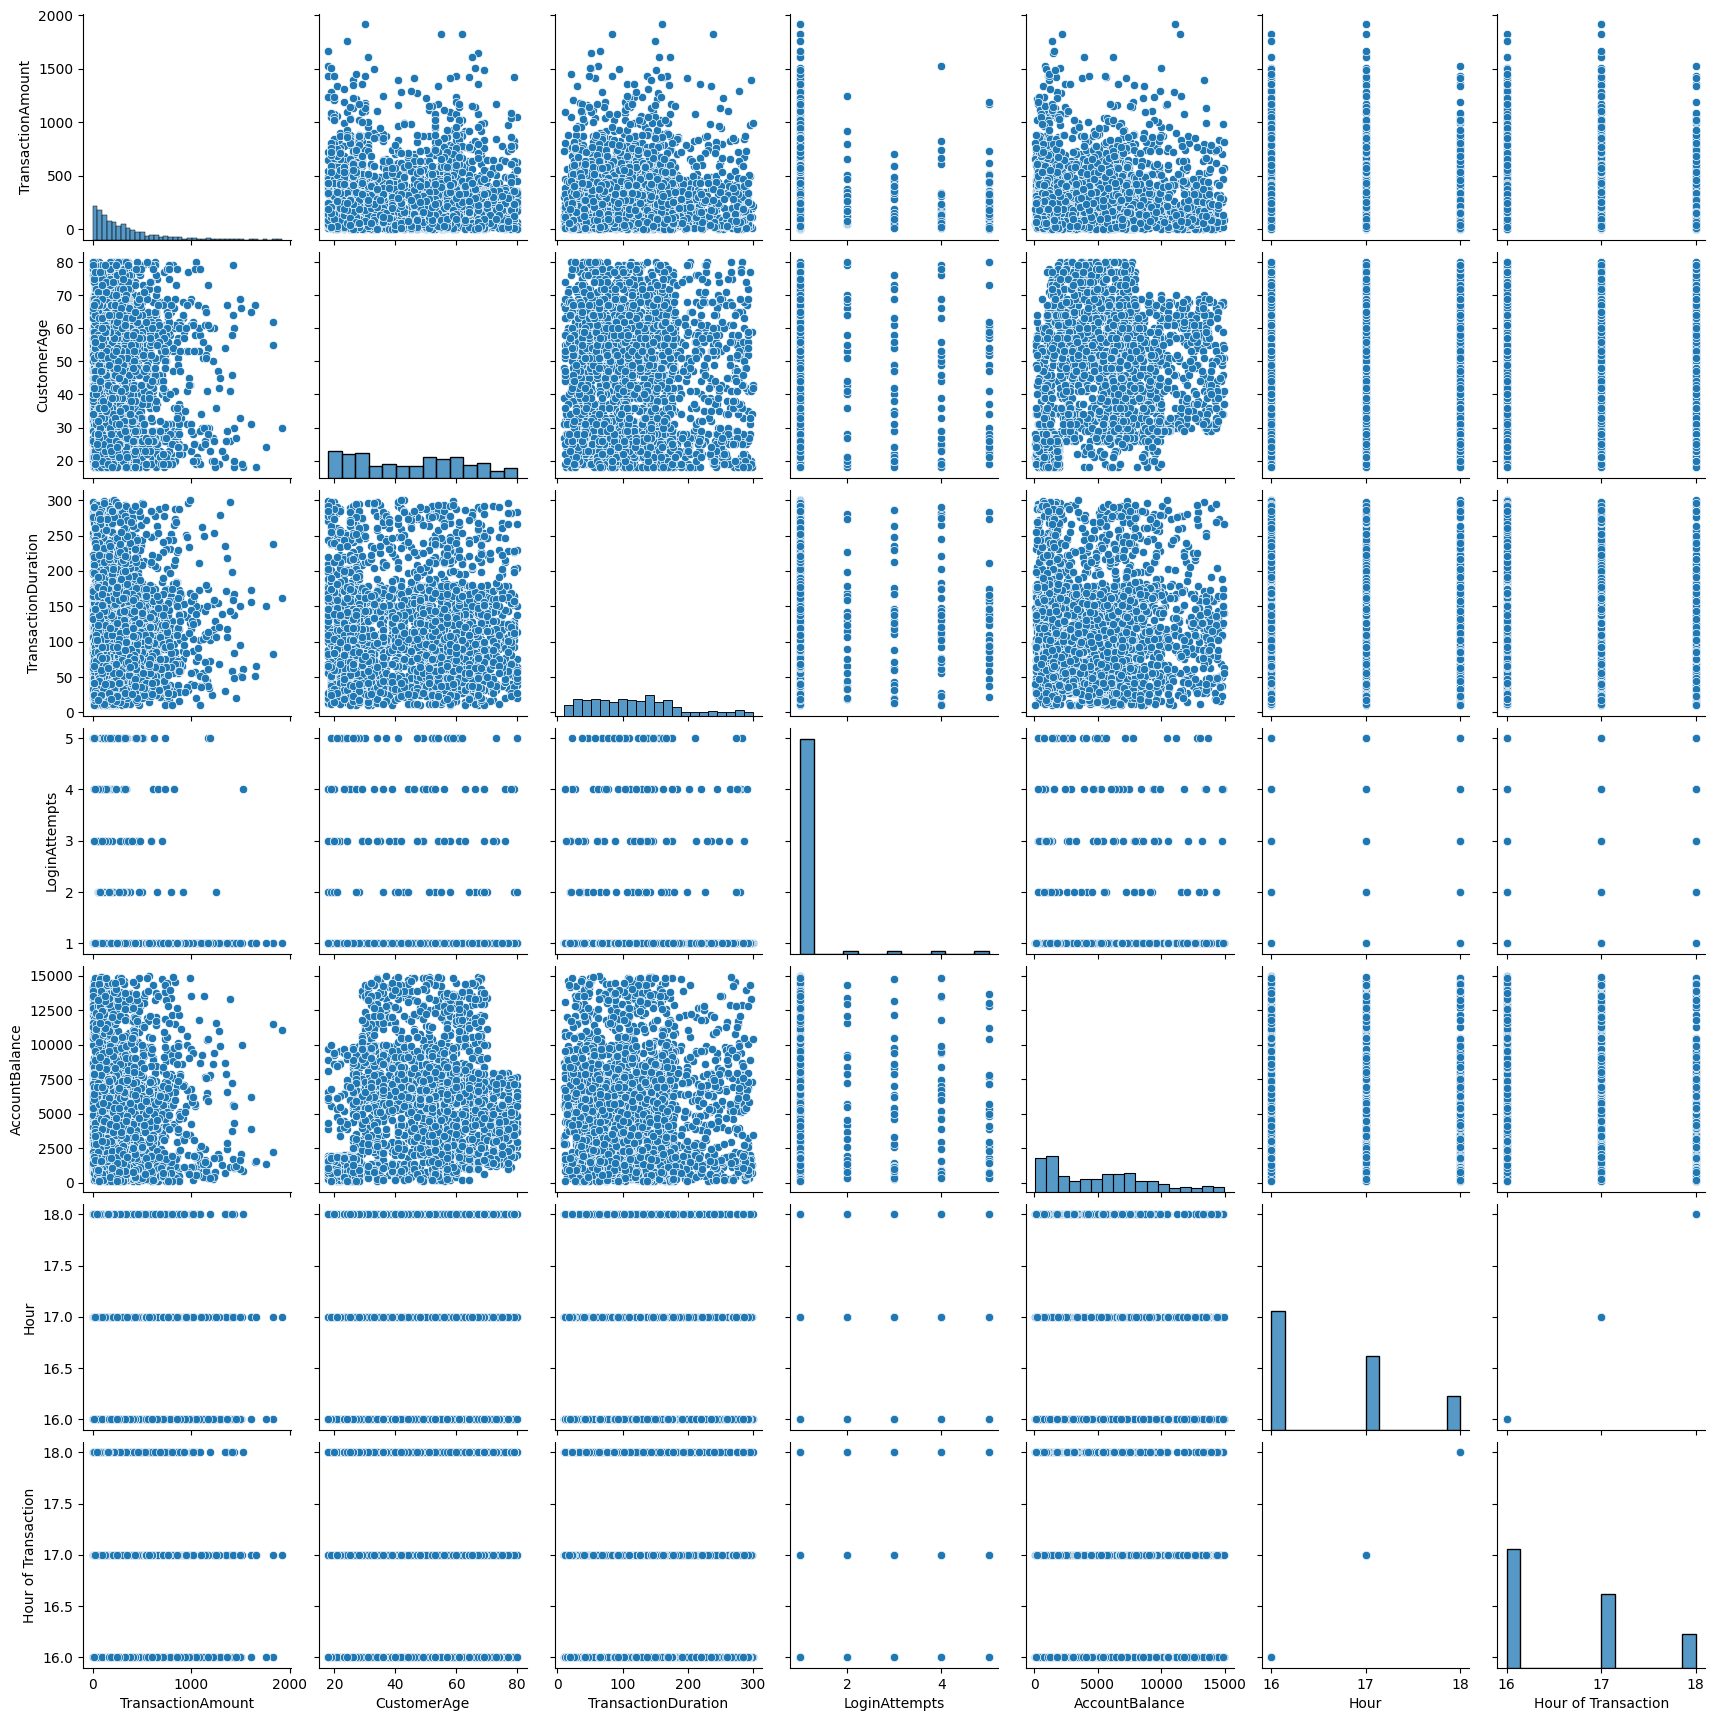

In [36]:
sns.pairplot(df)

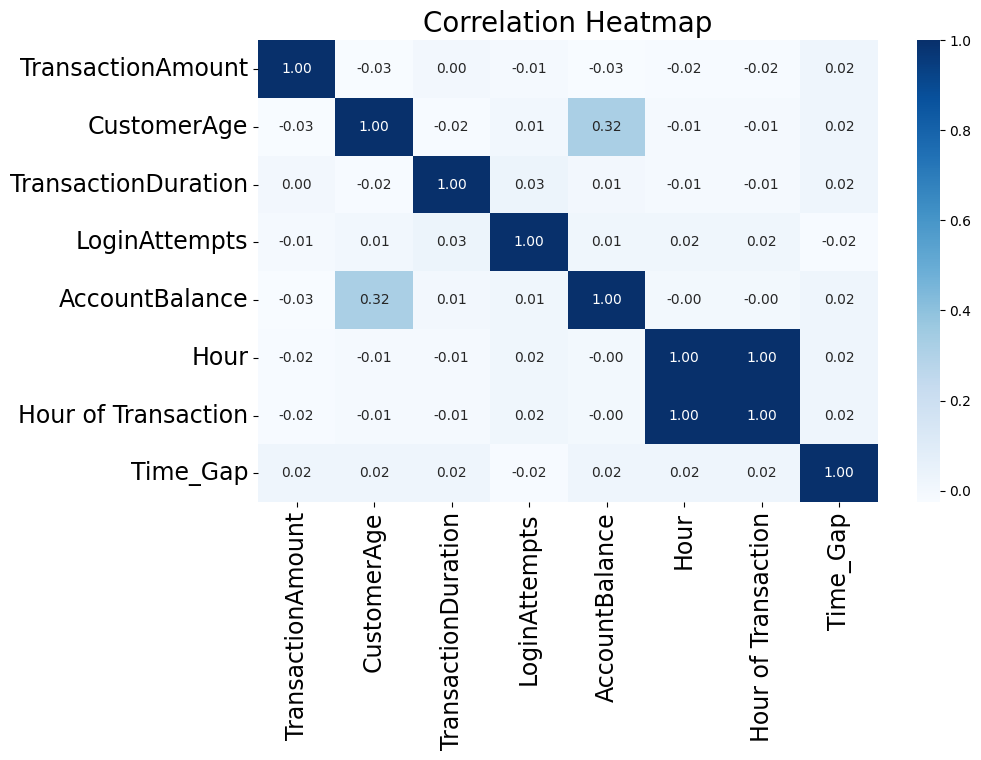

In [144]:
"""
erase some column that we don't need
Non-Numeric Features: CustomerOccupation, AccountID, and Channel...
Unique Identifiers: TransactionID, AccountID, DeviceID, and MerchantID
Redundant/Irrelevant Columns: TransactionDate, PreviousTransactionDate, IP Address
"""
df.drop(columns=['TransactionID', 'AccountID', 'TransactionDate', 'TransactionType', 'Location', 'DeviceID', 'MerchantID', 'PreviousTransactionDate', 'Channel', 'IP Address', 'CustomerOccupation'])
plt.figure(figsize=(10,6))

numeric_columns = df.select_dtypes(include=np.number).columns

correlation_matrix = df[numeric_columns].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.xticks(rotation=90, fontsize=17)
plt.yticks(fontsize=17)
plt.title('Correlation Heatmap', fontsize=20)
plt.show()

The correlation heatmap provides several key insights:

1. Customer Age has a moderate positive correlation (0.32) with Account Balance, suggesting older customers tend to have higher account balances.
2. most of features have weak positive correlations with each other, implying these features are likely related to the transaction process.

# **4. *Data Preparation***

In [145]:
# Check for duplicate rows
duplicates = df.duplicated().sum()

# Check for missing values
missing_values = df.isnull().sum().sum()

# Check for NaN values
nan_values = df.isna().sum().sum()

if duplicates == 0 and missing_values == 0 and nan_values == 0:
    print("The data is clean.")
else:
    print("The data has issues:")
    if duplicates > 0:
        print(f"There are {duplicates} duplicate rows.")
    if missing_values > 0:
        print(f"There are {missing_values} missing values.")
    if nan_values > 0:
        print(f"There are {nan_values} NaN values.")

The data is clean.


In [146]:
"""
Feature Selection, this features selected because these are intuitively relevant.
"""
features = ['TransactionAmount', 'CustomerAge']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **5. *Model Development***

## **5.1 *K-means Clustering***

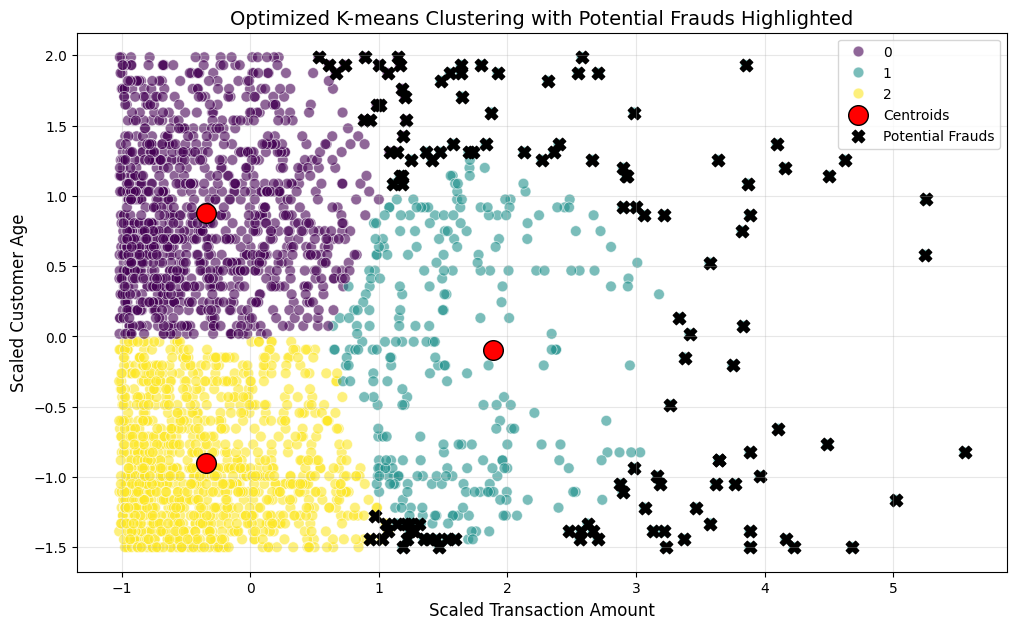

KMeans Silhouette Score: 0.46962506821788885
Number of clusters: 3
Fraud detection threshold (distance): 1.36
Number of potential frauds detected: 126
Fraudulent transactions account for 5.02% of all transactions.


In [166]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300)
kmeans_labels = kmeans.fit_predict(X_scaled)

df['KMeans_Cluster'] = kmeans_labels

distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans_labels], axis=1)

# Define threshold for potential frauds (top 5% farthest points from centroids)
percentile = 95
threshold = np.percentile(distances, percentile)
df['KMeans_Potential_Fraud'] = distances > threshold

frauds = df[df['KMeans_Potential_Fraud']]
non_frauds = df[~df['KMeans_Potential_Fraud']]

plt.figure(figsize=(12, 7))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=kmeans_labels, palette='viridis', s=60, alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=200, c='red', label='Centroids', edgecolors='black')
plt.scatter(X_scaled[distances > threshold, 0], X_scaled[distances > threshold, 1],
            color='black', s=80, label='Potential Frauds', marker='X')
plt.title('Optimized K-means Clustering with Potential Frauds Highlighted', fontsize=14)
plt.xlabel('Scaled Transaction Amount', fontsize=12)
plt.ylabel('Scaled Customer Age', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
print(f"KMeans Silhouette Score: {kmeans_silhouette}")
print(f"Number of clusters: {n_clusters}")
print(f"Fraud detection threshold (distance): {threshold:.2f}")
print(f"Number of potential frauds detected: {len(frauds)}")
print(f"Fraudulent transactions account for {len(frauds) / len(df) * 100:.2f}% of all transactions.")

## **5.2 *DBSCAN Clustering***

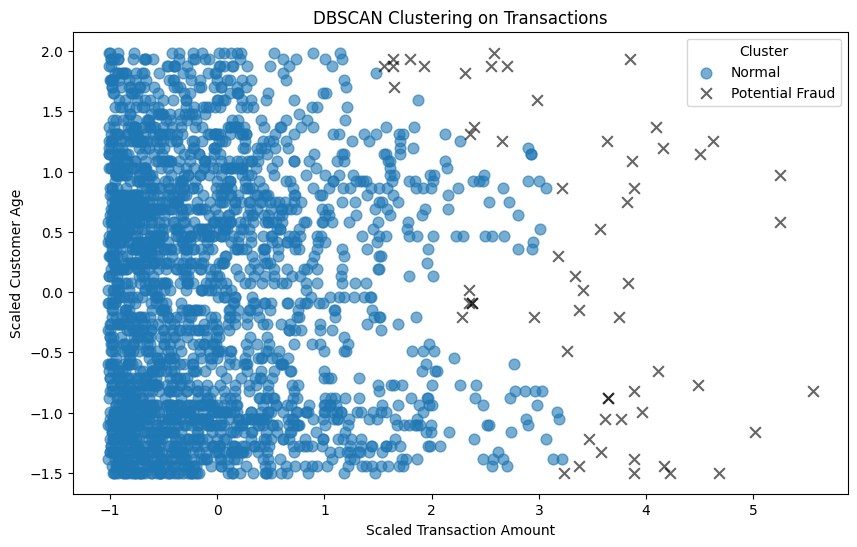

Silhouette Score: 0.5437089419372249
Number of clusters: 1
Number of potential frauds detected: 59
Fraudulent transactions account for 2.35% of all transactions.


In [167]:
dbscan = DBSCAN(eps=0.3, min_samples=8)  # i adjust this manually to get best Silhouette Score
dbscan_labels = dbscan.fit_predict(X_scaled)

df['DBSCAN_Potential_Fraud'] = dbscan_labels
label_mapping = {-1: 'Potential Fraud', 0: 'Normal', 1: 'Suspicious Group 1', 2: 'Suspicious Group 2'}
df['DBSCAN_Potential_Fraud'] = df['DBSCAN_Potential_Fraud'].map(label_mapping)

plt.figure(figsize=(10, 6))
for cluster in df['DBSCAN_Potential_Fraud'].unique():
    if cluster == 'Potential Fraud':
        plt.scatter(X_scaled[df['DBSCAN_Potential_Fraud'] == cluster, 0],
                    X_scaled[df['DBSCAN_Potential_Fraud'] == cluster, 1],
                    color='black', marker='x', s=60, alpha=0.6, label=cluster)
    else:
        plt.scatter(X_scaled[df['DBSCAN_Potential_Fraud'] == cluster, 0],
                    X_scaled[df['DBSCAN_Potential_Fraud'] == cluster, 1],
                    s=60, alpha=0.6, label=cluster)

plt.title('DBSCAN Clustering on Transactions')
plt.xlabel('Scaled Transaction Amount')
plt.ylabel('Scaled Customer Age')
plt.legend(title='Cluster')
plt.show()

silhouette = silhouette_score(X_scaled, dbscan_labels)
print(f"Silhouette Score: {silhouette}")

num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"Number of clusters: {num_clusters}")

potential_frauds = df[df['DBSCAN_Potential_Fraud'] == 'Potential Fraud']
num_frauds = len(potential_frauds)
print(f"Number of potential frauds detected: {num_frauds}")

fraud_percentage = (num_frauds / len(df)) * 100
print(f"Fraudulent transactions account for {fraud_percentage:.2f}% of all transactions.")

## **5.3 *Isolation Forest Clustering***

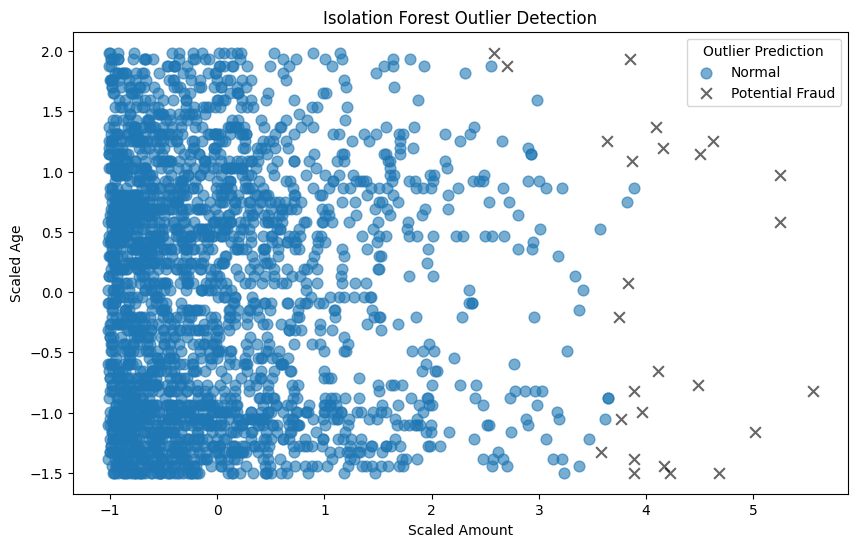

Number of potential frauds detected: 26
Fraudulent transactions account for 1.04% of all transactions.


In [168]:
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outlier_pred = iso_forest.fit_predict(X_scaled)

outlier_mapping = {1: 'Normal', -1: 'Potential Fraud'}
df['IsoFores_Potential_Fraud'] = pd.Series(outlier_pred).map(outlier_mapping)

plt.figure(figsize=(10, 6))
for prediction in df['IsoFores_Potential_Fraud'].unique():
    if prediction == 'Potential Fraud':
        plt.scatter(X_scaled[df['IsoFores_Potential_Fraud'] == prediction, 0],
                    X_scaled[df['IsoFores_Potential_Fraud'] == prediction, 1],
                    color='black', marker='x', s=60, alpha=0.6, label=prediction)
    else:
        plt.scatter(X_scaled[df['IsoFores_Potential_Fraud'] == prediction, 0],
                    X_scaled[df['IsoFores_Potential_Fraud'] == prediction, 1],
                    s=60, alpha=0.6, label=prediction)

plt.title('Isolation Forest Outlier Detection')
plt.xlabel('Scaled Amount')
plt.ylabel('Scaled Age')
plt.legend(title='Outlier Prediction')
plt.show()

num_frauds = len(df[df['IsoFores_Potential_Fraud'] == 'Potential Fraud'])
print(f"Number of potential frauds detected: {num_frauds}")
fraud_percentage = (num_frauds / len(df)) * 100
print(f"Fraudulent transactions account for {fraud_percentage:.2f}% of all transactions.")


# **6. *Model Evaluation***
since this approach used unsupervised learning we will evaluate clustering model from it's Silhouette Score, result, and show threat level charts



KMeans Silhouette Score: 0.46962506821788885
Number of clusters: 3
Fraud detection threshold (distance): 1.36
Number of potential frauds detected: 126
Fraudulent transactions account for 5.02% of all transactions.
--------------------------------------------------------------------------------
Silhouette Score: 0.5437089419372249
Number of clusters: 1
Number of potential frauds detected: 59
Fraudulent transactions account for 2.35% of all transactions.
--------------------------------------------------------------------------------
Number of potential frauds detected: 26
Fraudulent transactions account for 1.04% of all transactions.


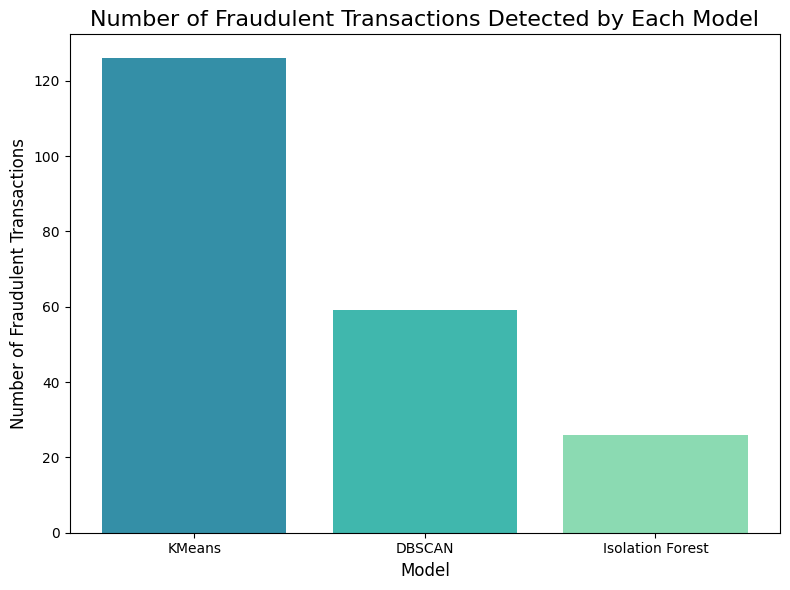

In [171]:
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
print(f"KMeans Silhouette Score: {kmeans_silhouette}")
print(f"Number of clusters: {n_clusters}")
print(f"Fraud detection threshold (distance): {threshold:.2f}")
print(f"Number of potential frauds detected: {len(frauds)}")
print(f"Fraudulent transactions account for {len(frauds) / len(df) * 100:.2f}% of all transactions.")
print("-" * 80)

DBSCAN_silhouette = silhouette_score(X_scaled, dbscan_labels)
print(f"Silhouette Score: {DBSCAN_silhouette}")
num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"Number of clusters: {num_clusters}")
potential_frauds = df[df['DBSCAN_Potential_Fraud'] == 'Potential Fraud']
num_frauds = len(potential_frauds)
print(f"Number of potential frauds detected: {num_frauds}")
fraud_percentage = (num_frauds / len(df)) * 100
print(f"Fraudulent transactions account for {fraud_percentage:.2f}% of all transactions.")
print("-" * 80)

num_frauds = len(df[df['IsoFores_Potential_Fraud'] == 'Potential Fraud'])
print(f"Number of potential frauds detected: {num_frauds}")
fraud_percentage = (num_frauds / len(df)) * 100
print(f"Fraudulent transactions account for {fraud_percentage:.2f}% of all transactions.")

fraud_counts = {
    "KMeans": len(df[df['KMeans_Potential_Fraud'] == True]),
    "DBSCAN": len(df[df['DBSCAN_Potential_Fraud'] == 'Potential Fraud']),
    "Isolation Forest": len(df[df['IsoFores_Potential_Fraud'] == 'Potential Fraud'])
}

plt.figure(figsize=(8, 6))
plt.bar(fraud_counts.keys(), fraud_counts.values(), color=[palette[3], palette[4], palette[5]])
plt.title("Number of Fraudulent Transactions Detected by Each Model", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Number of Fraudulent Transactions", fontsize=12)
plt.tight_layout()
plt.show()

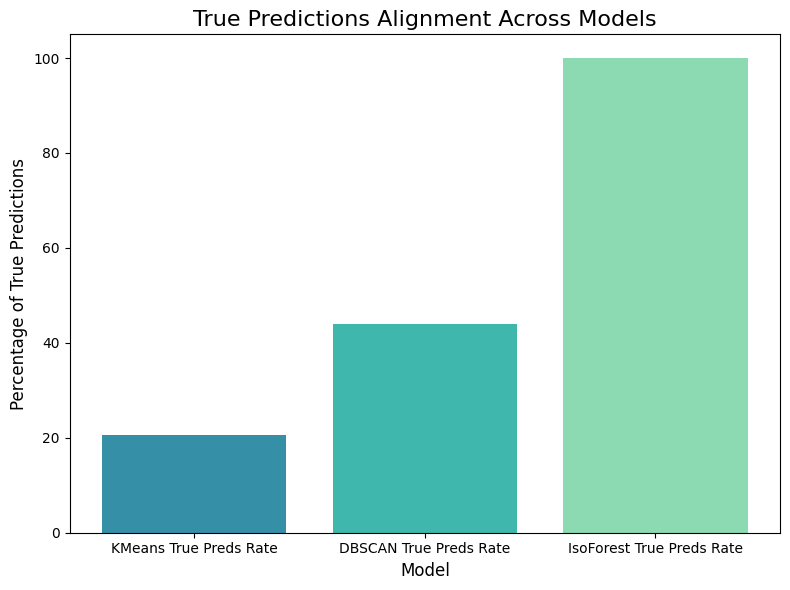

In [179]:
kmeans_true_rate = sum((df['KMeans_Potential_Fraud'] == True) &
                       (df['DBSCAN_Potential_Fraud'] == True) &
                       (df['IsoFores_Potential_Fraud'] == True)) / sum(df['KMeans_Potential_Fraud'] == True) * 100

dbscan_true_rate = sum((df['DBSCAN_Potential_Fraud'] == True) &
                       (df['KMeans_Potential_Fraud'] == True) &
                       (df['IsoFores_Potential_Fraud'] == True)) / sum(df['DBSCAN_Potential_Fraud'] == True) * 100

isoforest_true_rate = sum((df['IsoFores_Potential_Fraud'] == True) &
                          (df['KMeans_Potential_Fraud'] == True) &
                          (df['DBSCAN_Potential_Fraud'] == True)) / sum(df['IsoFores_Potential_Fraud'] == True) * 100

true_pred_rates = pd.DataFrame({
    'KMeans True Preds Rate': [kmeans_true_rate],
    'DBSCAN True Preds Rate': [dbscan_true_rate],
    'IsoForest True Preds Rate': [isoforest_true_rate]
})

plt.figure(figsize=(8, 6))
plt.bar(true_pred_rates.columns, true_pred_rates.iloc[0], color=[palette[3], palette[4], palette[5]])
plt.title("True Predictions Alignment Across Models", fontsize=16)
plt.ylabel("Percentage of True Predictions", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [159]:
df[df['KMeans_Potential_Fraud'] == True].head(10)

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,...,DayOfWeek,Hour,Hour of Transaction,Time_Gap,KMeans_Cluster,KMeans_Potential_Fraud,DBSCAN_Cluster,IsoForest_Prediction,DBSCAN_Potential_Fraud,IsoFores_Potential_Fraud
37,TX000038,AC00202,649.28,2023-03-02 17:53:32,Debit,San Jose,D000448,73.108.76.238,M074,ATM,...,Thursday,17,17,-613 days +09:42:17,0,True,Normal,Normal,Normal,Normal
74,TX000075,AC00265,1212.51,2023-10-04 16:36:29,Debit,Indianapolis,D000231,193.83.0.183,M036,Branch,...,Wednesday,16,16,-397 days +08:29:38,1,True,Normal,Normal,Normal,Normal
85,TX000086,AC00098,1340.19,2023-09-29 17:22:10,Credit,Austin,D000574,165.114.224.47,M012,Online,...,Friday,17,17,-402 days +09:15:17,1,True,Potential Fraud,Normal,Potential Fraud,Normal
138,TX000139,AC00405,997.43,2023-11-22 16:07:19,Debit,Seattle,D000661,100.4.40.132,M067,Online,...,Wednesday,16,16,-348 days +07:58:54,1,True,Potential Fraud,Normal,Potential Fraud,Normal
141,TX000142,AC00114,1049.92,2023-10-23 16:50:33,Debit,Detroit,D000522,121.67.144.20,M052,ATM,...,Monday,16,16,-378 days +08:39:59,1,True,Potential Fraud,Potential Fraud,Potential Fraud,Potential Fraud
146,TX000147,AC00385,973.39,2023-08-30 17:23:20,Debit,Sacramento,D000292,202.194.199.70,M026,Branch,...,Wednesday,17,17,-432 days +09:11:36,1,True,Potential Fraud,Normal,Potential Fraud,Normal
157,TX000158,AC00111,803.37,2023-04-17 16:08:34,Credit,Memphis,D000108,191.91.45.159,M030,Branch,...,Monday,16,16,-567 days +07:59:54,1,True,Normal,Normal,Normal,Normal
176,TX000177,AC00363,1362.55,2023-02-10 18:07:07,Debit,El Paso,D000213,93.52.44.101,M001,ATM,...,Friday,18,18,-633 days +09:56:02,1,True,Potential Fraud,Normal,Potential Fraud,Normal
186,TX000187,AC00099,1041.88,2023-09-06 16:44:02,Debit,Jacksonville,D000208,32.240.176.64,M032,Online,...,Wednesday,16,16,-425 days +08:37:18,1,True,Potential Fraud,Normal,Potential Fraud,Normal
190,TX000191,AC00396,1422.55,2023-07-10 17:49:18,Debit,Washington,D000569,188.124.181.12,M072,Branch,...,Monday,17,17,-483 days +09:42:28,1,True,Potential Fraud,Potential Fraud,Potential Fraud,Potential Fraud


In [172]:
"""
update [IsoFores_Potential_Fraud] and [DBSCAN_Potential_Fraud] columns based on the condition where their value is "Potential Fraud",
"""
df['IsoFores_Potential_Fraud'] = df['IsoForest_Prediction'] == 'Potential Fraud'
df['DBSCAN_Potential_Fraud'] = df['DBSCAN_Cluster'] == 'Potential Fraud'

In [173]:
df[df['KMeans_Potential_Fraud'] == True].head(10)

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,...,Hour,Hour of Transaction,Time_Gap,KMeans_Cluster,KMeans_Potential_Fraud,DBSCAN_Cluster,IsoForest_Prediction,DBSCAN_Potential_Fraud,IsoFores_Potential_Fraud,Threat_Level
37,TX000038,AC00202,649.28,2023-03-02 17:53:32,Debit,San Jose,D000448,73.108.76.238,M074,ATM,...,17,17,-613 days +09:42:17,0,True,Normal,Normal,False,False,1
74,TX000075,AC00265,1212.51,2023-10-04 16:36:29,Debit,Indianapolis,D000231,193.83.0.183,M036,Branch,...,16,16,-397 days +08:29:38,1,True,Normal,Normal,False,False,1
85,TX000086,AC00098,1340.19,2023-09-29 17:22:10,Credit,Austin,D000574,165.114.224.47,M012,Online,...,17,17,-402 days +09:15:17,1,True,Potential Fraud,Normal,True,False,2
138,TX000139,AC00405,997.43,2023-11-22 16:07:19,Debit,Seattle,D000661,100.4.40.132,M067,Online,...,16,16,-348 days +07:58:54,1,True,Potential Fraud,Normal,True,False,2
141,TX000142,AC00114,1049.92,2023-10-23 16:50:33,Debit,Detroit,D000522,121.67.144.20,M052,ATM,...,16,16,-378 days +08:39:59,1,True,Potential Fraud,Potential Fraud,True,True,3
146,TX000147,AC00385,973.39,2023-08-30 17:23:20,Debit,Sacramento,D000292,202.194.199.70,M026,Branch,...,17,17,-432 days +09:11:36,1,True,Potential Fraud,Normal,True,False,2
157,TX000158,AC00111,803.37,2023-04-17 16:08:34,Credit,Memphis,D000108,191.91.45.159,M030,Branch,...,16,16,-567 days +07:59:54,1,True,Normal,Normal,False,False,1
176,TX000177,AC00363,1362.55,2023-02-10 18:07:07,Debit,El Paso,D000213,93.52.44.101,M001,ATM,...,18,18,-633 days +09:56:02,1,True,Potential Fraud,Normal,True,False,2
186,TX000187,AC00099,1041.88,2023-09-06 16:44:02,Debit,Jacksonville,D000208,32.240.176.64,M032,Online,...,16,16,-425 days +08:37:18,1,True,Potential Fraud,Normal,True,False,2
190,TX000191,AC00396,1422.55,2023-07-10 17:49:18,Debit,Washington,D000569,188.124.181.12,M072,Branch,...,17,17,-483 days +09:42:28,1,True,Potential Fraud,Potential Fraud,True,True,3


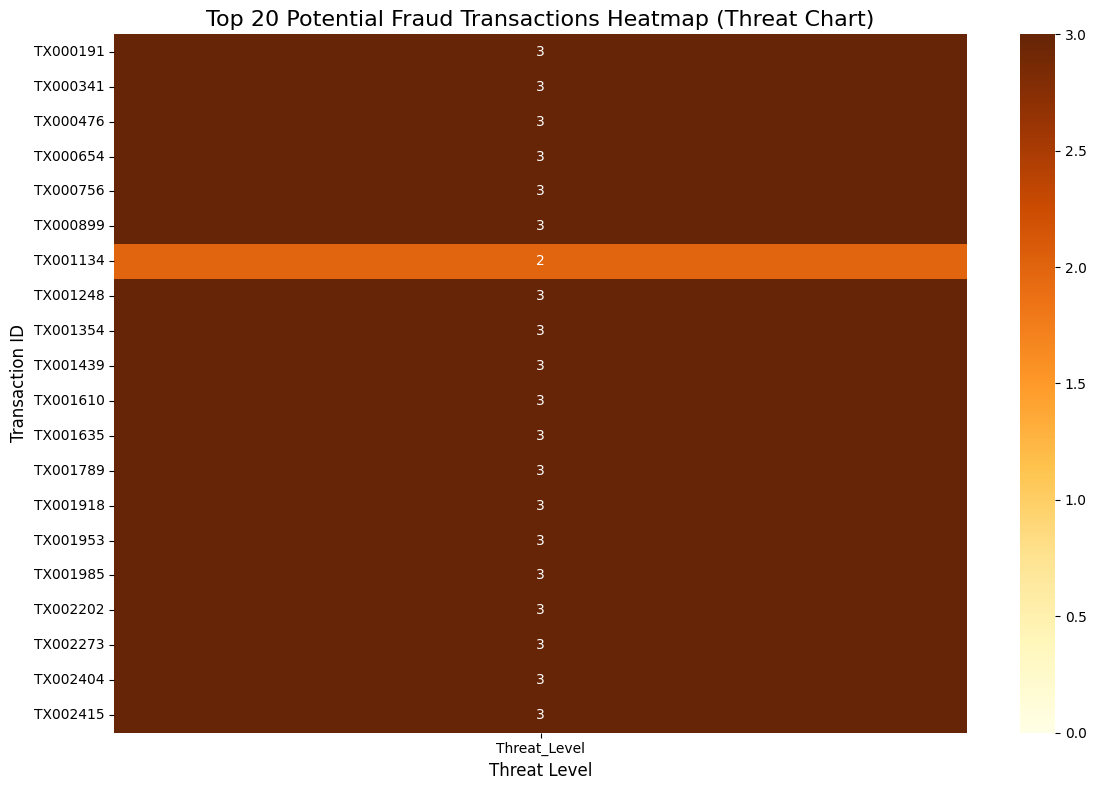

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

top_20_data = df[df['Threat_Level'] > 1].nlargest(20, 'TransactionAmount')

heatmap_data = top_20_data.pivot_table(
    index='TransactionID',
    values='Threat_Level'
)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap="YlOrBr",
    vmin=0,
    vmax=3,
    cbar=True
)

plt.title("Top 20 Potential Fraud Transactions Heatmap (Threat Chart)", fontsize=16)
plt.xlabel("Threat Level", fontsize=12)
plt.ylabel("Transaction ID", fontsize=12)
plt.tight_layout()

plt.show()


From the evaluation carried out it was found that:

1. Kmeans clustering is the most sensitive model in predicting potential fraud, followed by DBScan, and Isolation Forest
2. In the other hand, the suitability of Isolation Forest predictions has the highest level of suitability when compared to other model answers.
3. Prediction results are better if assessed via the Threat map which is the combined result of predictions from all models
